## Introduction

This Notebook shows how to perform a quick analysis on simple time series by using basic Pandas and Seaborn commands to generate heatmaps.
The similar techniques can be used on any dataset containing just a date and value columns (number of sales, users accesses…).  
I hope the same steps can be useful when analyzing any time series dataset.

Let's start by importing the needed libraries, also setting retina resolution for plots and ggplot style.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.style as style
import missingno as msno

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

style.use('ggplot')

### Dataset  

I'm using a dataset downloaded from the National Centers for Environmental Information (NCEI), the data is in the public domain and can be used freely.  
In case using the same dataset or generating a new one from NCEI you need to cite the origin.  
The Dataset covers each day from 2010 to 2019 and the station used is located at Heathrow Airport in London.

**DATE**: is the year of the record (4 digits) followed by month (2 digits) and day (2 digits).  
**PRCP**: Precipitation (mm)  
**TAVG**: Average temperature (°C)  

In [4]:
df = pd.read_csv('/Volumes/DataLakeActive/RZR Rider Profile Dashboard/data/gpx_rzr_all/gpx_rzr_all-single_export_polars_df.csv', 
                               usecols=['timestamp', 'speed', 'elevation'], parse_dates=['timestamp'])
#df['DATE'] = df['DATE'].astype('datetime64[ns]') # needed if date format is not standard
df.columns = ['elevation', 'datetime', 'speed']
df.sample(3)

,elevation,datetime,speed
171494,600.557762,2023-06-24 18:54:47,56.655034
76070,928.510528,2024-04-17 00:21:40,78.758860
151617,951.542025,2023-09-21 17:31:29,77.815828


In [5]:
df.dtypes

elevation           float64
datetime     datetime64[ns]
speed               float64
dtype: object

In [6]:
len(df)

241752

Let's check if there are missing values

In [7]:
df.isnull().sum()

elevation    0
datetime     0
speed        0
dtype: int64

In [8]:
round(df.isnull().mean() * 100, 2)

elevation    0.0
datetime     0.0
speed        0.0
dtype: float64

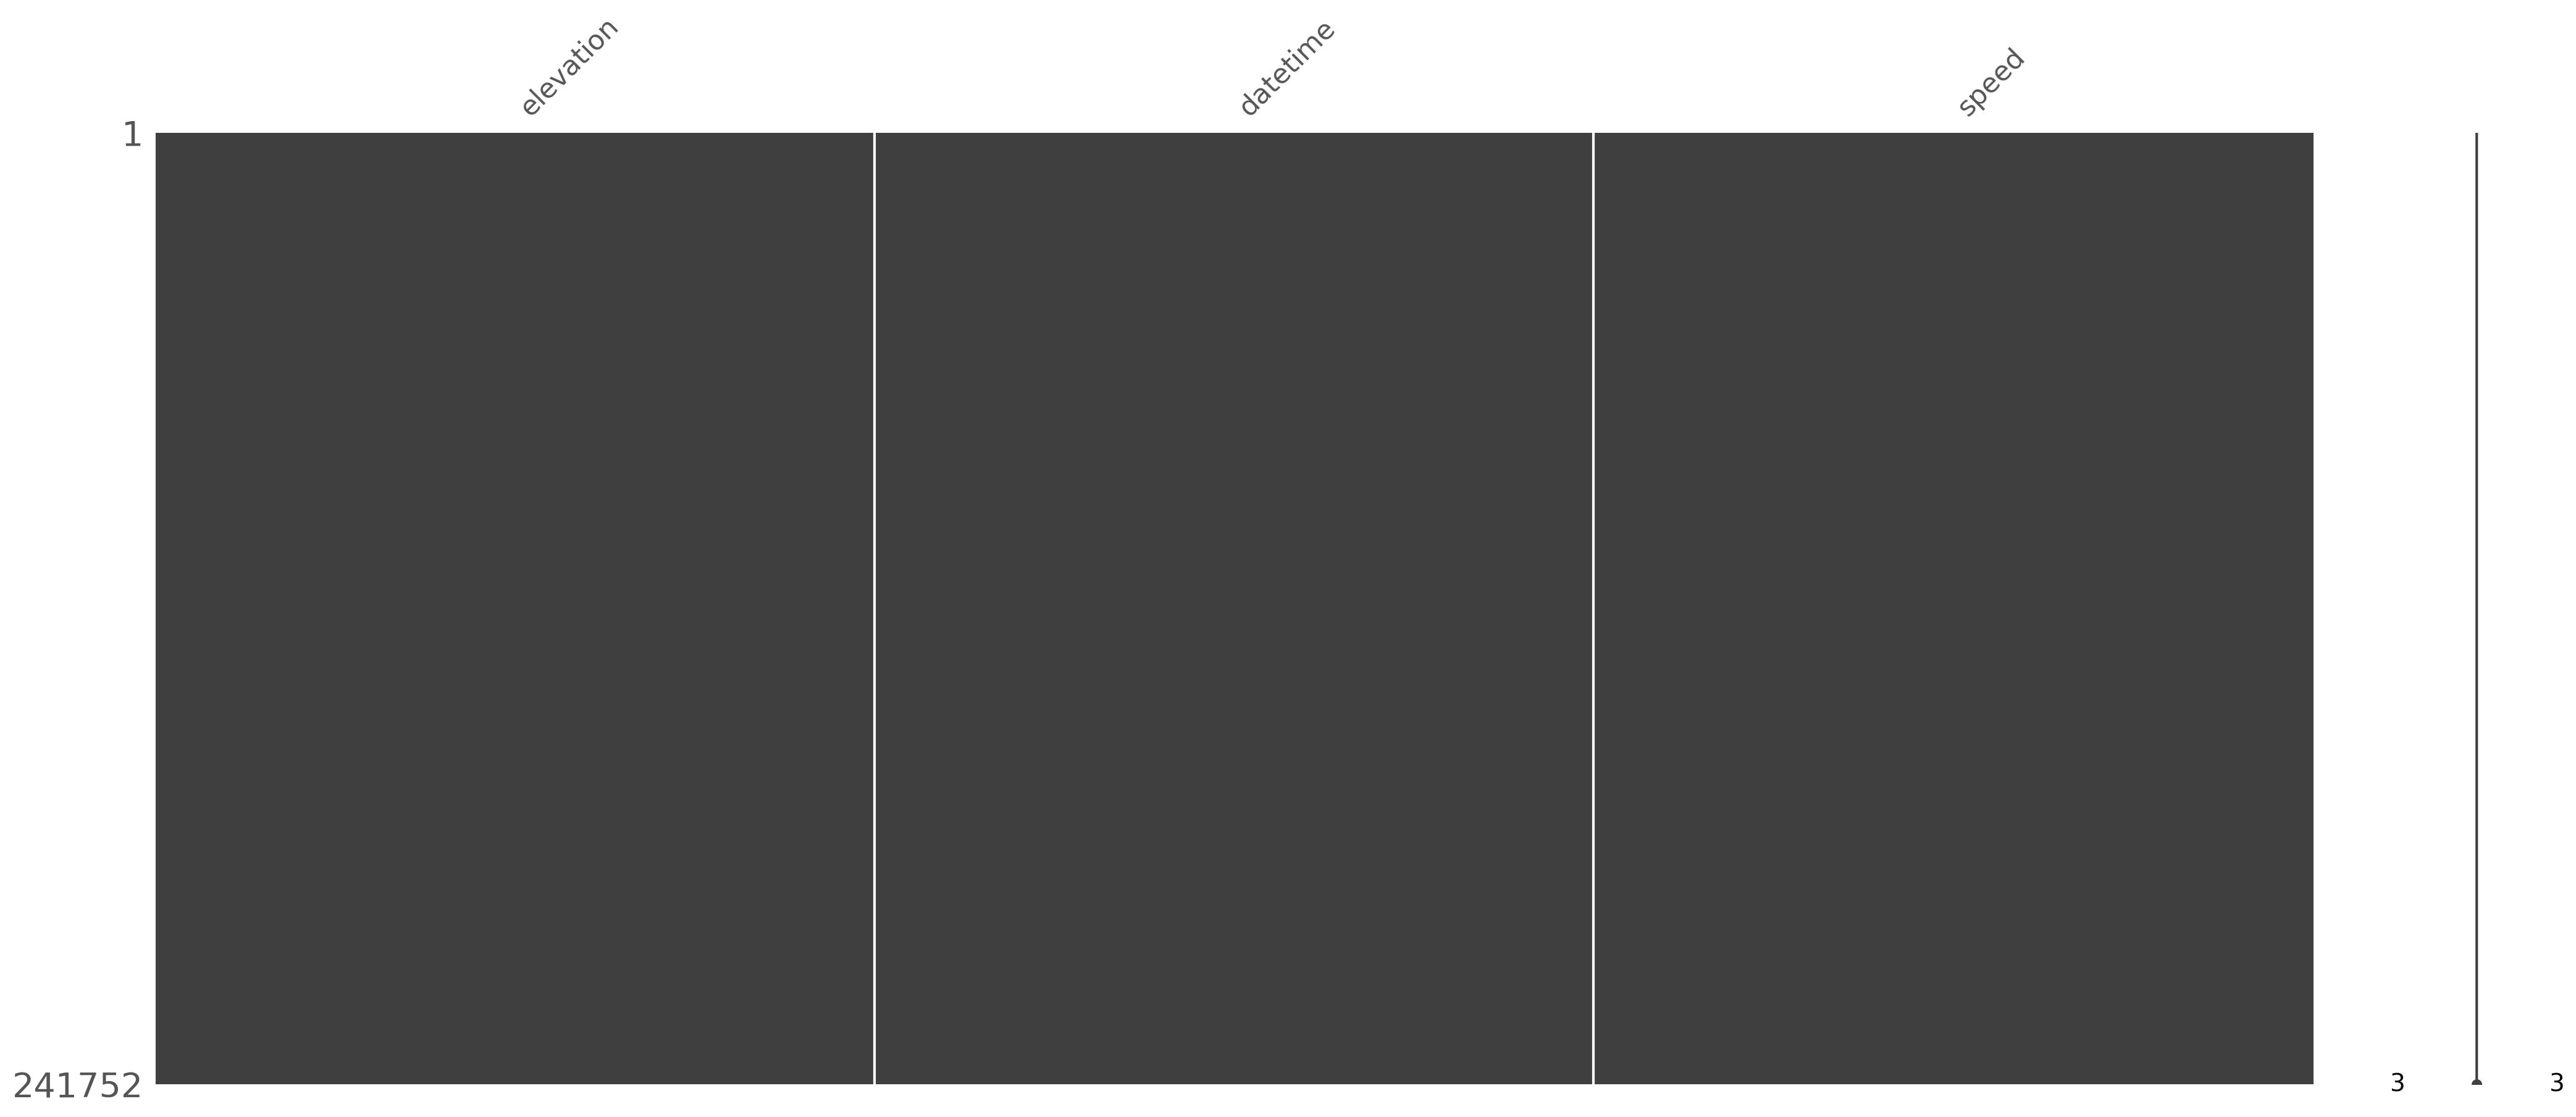

In [9]:
_ = msno.matrix(df)

In this case we will fill the null values with 0.0 (in this case meaning no rain), this is to make the rest of the analysis simpler (like when summing up) but this may change depending on your dataset.

In [ ]:
df['speed'].fillna(0, inplace=True)

We also want to check if there are missing days in the range

In [ ]:
print(f"Data Available from {= df['datetime']..min()} to {= df['datetime']..max()}")

In [ ]:
idx = pd.date_range(= df['datetime']..min(), = df['datetime']..max())
print(f"Days present {len(df)} out of {len(idx)}")

Some days are missing, let's create a DataFrame to visualize them.

In [ ]:
pd.DataFrame(data=idx.difference(= df['datetime'].), columns=['dates']).sample(3)

According to the MET Office a day can be considered dry if precipitation is less than 1mm.  
Let's see what is the percentage of dry days in the entire dataset.

In [15]:
SLOW_SPEED = 20.0

In [17]:
round((len(df[df['speed'] < SLOW_SPEED]) / len(df)) * 100, 2)

14.9

Find day with the highest precpitation.

In [ ]:
df[df.speed == df.speed.max()][['date', 'speed']]

And highest temperature

In [ ]:
df[df.avg_temp == df.avg_temp.max()][['date', 'avg_temp']]

In [ ]:
sns.distplot(df.speed)

In order to create the needed visualizations it can be useful to augment the dataframe with additional columns representing date infos.  
This step is not strictly needed because we could just use the same methods when later grouping.

In [14]:
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['day'] = df['datetime'].dt.day
df['weekdayName'] = df['datetime'].dt.day_name() # = df['datetime']..dt.weekday_name on older Pandas
df['weekday'] = df['datetime'].dt.weekday
df['week'] = df['datetime'].dt.week
df['weekend'] = df['datetime'].dt.weekday // 5 == 1

/var/folders/80/5h9bppcj40s4vt1zyzlcwcbc0000gn/T/ipykernel_12096/158982096.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.week


In [18]:
df['fast'] = df['speed'].gt(SLOW_SPEED).astype('int')

In [19]:
df.sample(3)

,elevation,datetime,speed,month,year,day,weekdayName,weekday,week,weekend,fast
85540,803.576141,2024-04-08 15:53:06,67.912257,4,2024,8,Monday,0,15,False,1
56938,931.102392,2024-05-17 22:50:37,5.240414,5,2024,17,Friday,4,20,False,0
8675,962.565648,2024-05-17 23:44:45,78.070187,5,2024,17,Friday,4,20,False,1


We could create a heatmap representing the average precipitation for every month in the dataset.  
To do so we can use the pivot_table function:

In [21]:
all_month_year_df = pd.pivot_table(df, values="speed",index=["month"],
                                   columns=["year"],
                                   fill_value=0,
                                   margins=True)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]]
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df

year,2023,2024,All
Feb,0.000000,101.016441,101.016441
Mar,0.000000,60.337728,60.337728
Apr,0.000000,53.509269,53.509269
May,63.502747,63.783500,63.765066
Jun,56.122585,60.091597,57.942600
Jul,47.241887,0.000000,47.241887
Aug,55.586169,0.000000,55.586169
Sep,58.345198,0.000000,58.345198
Oct,66.343591,0.000000,66.343591
Nov,55.845563,0.000000,55.845563


In [24]:
def plot_heatmap(df, title):
    plt.figure(figsize = (14, 10))
    ax = sns.heatmap(df, cmap='RdYlGn_r',
                     robust=True,
                     fmt='.2f', annot=True,
                     linewidths=.5, annot_kws={'size':11},
                     cbar_kws={'shrink':.8, 'label':'Speed (mm)'})
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    plt.title(title, fontdict={'fontsize':18}, pad=14);

robust or vmin, vmax

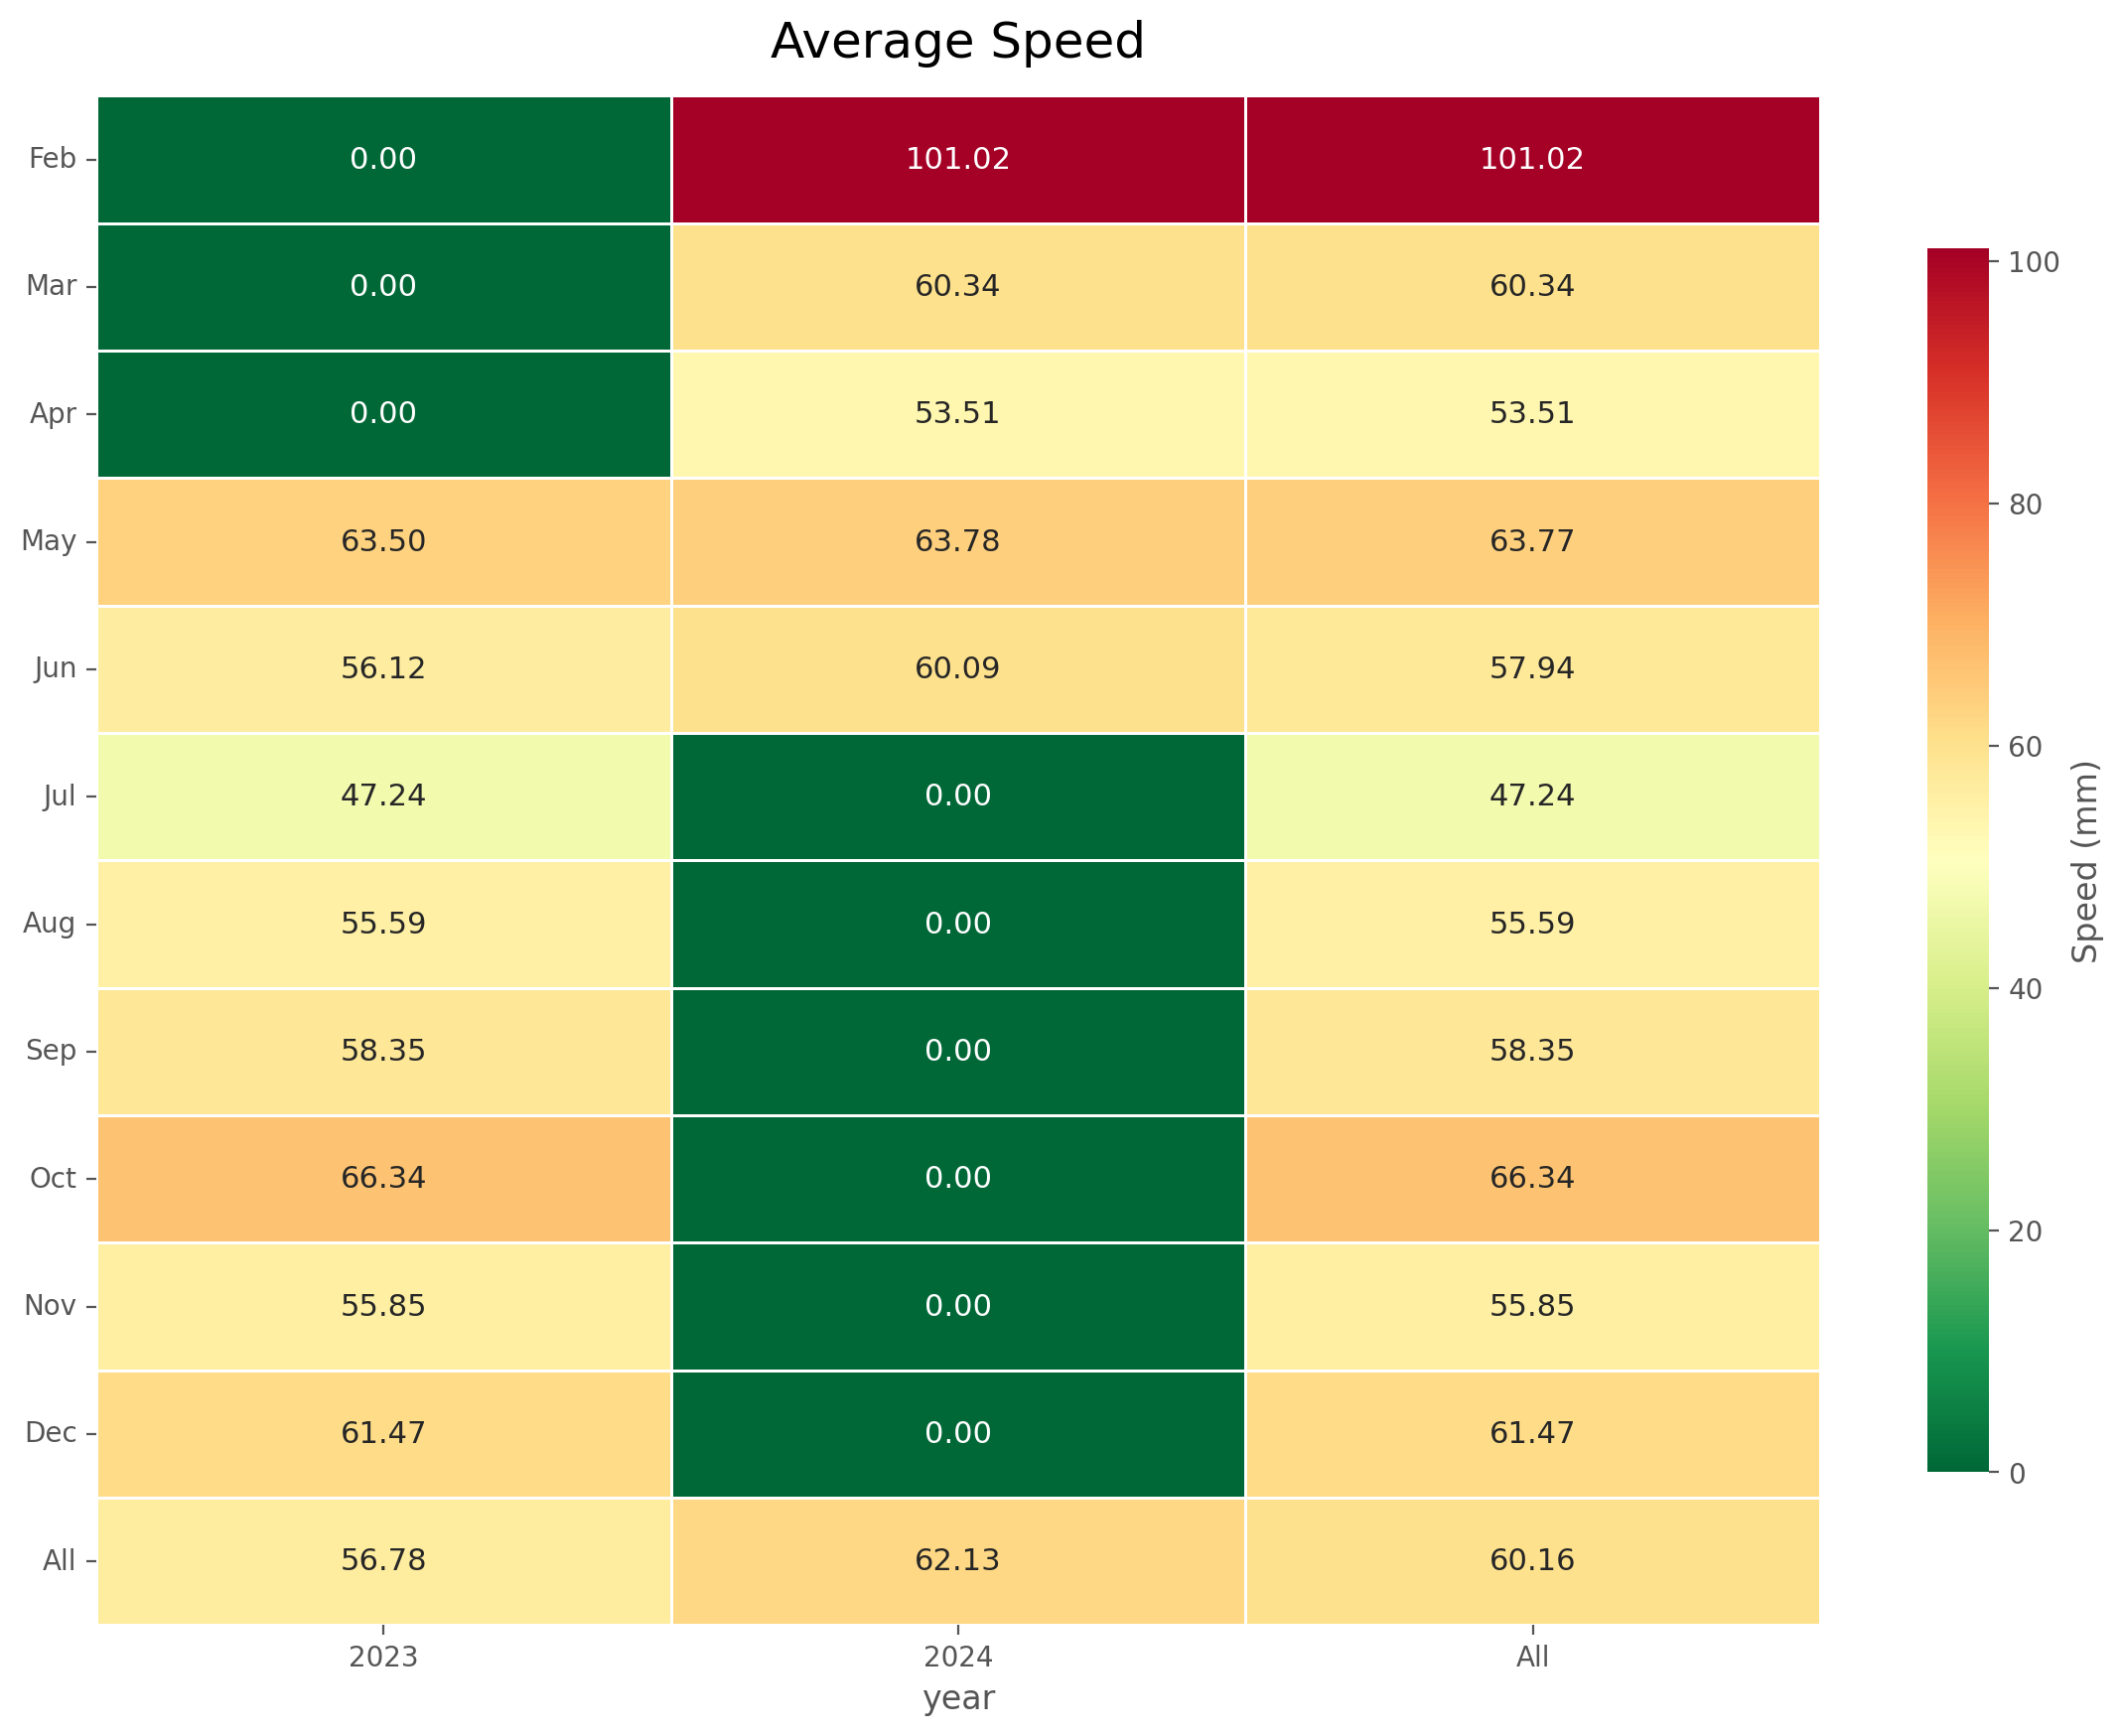

In [25]:
plot_heatmap(all_month_year_df, 'Average Speed')

By changing the aggfunc on pivot_table creation we can have a different aggregation, for instance we can use aggfunc=np.sum to calculate the total amount of rainfall per month.

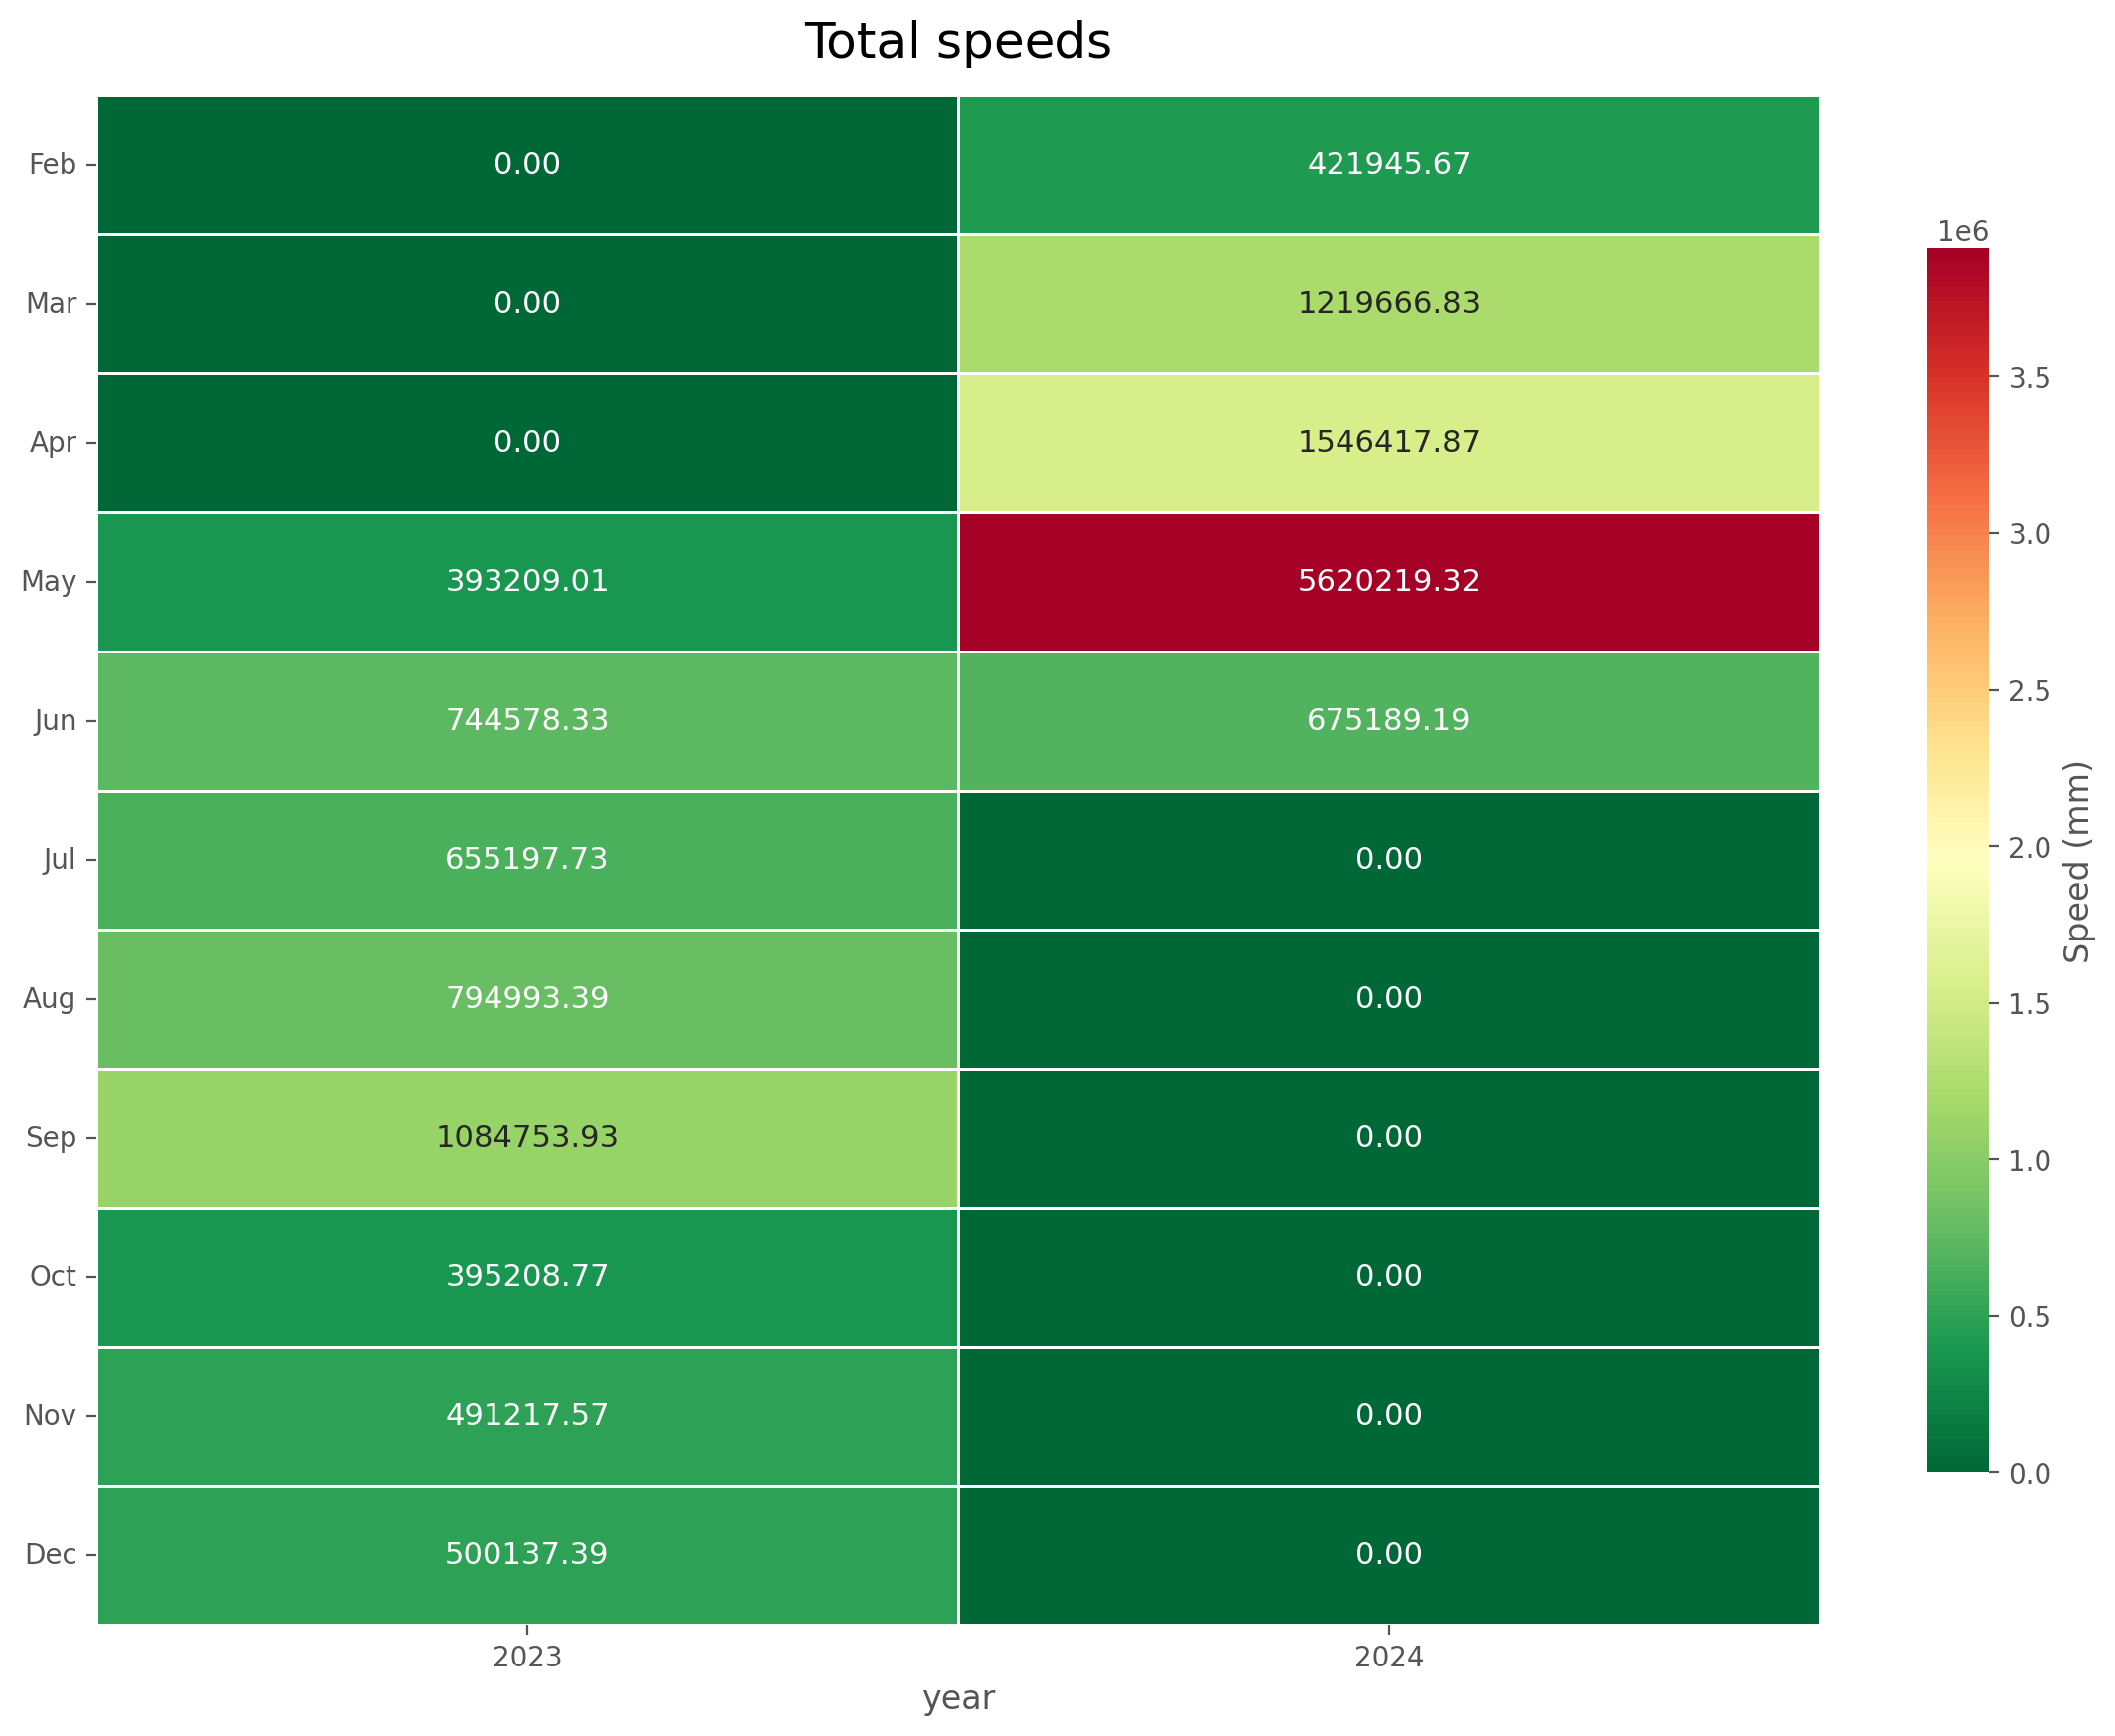

In [27]:
all_month_year_sum_df = pd.pivot_table(df, values="speed",index=["month"], columns=["year"], aggfunc=np.sum, fill_value=0)
all_month_year_sum_df = all_month_year_sum_df.set_index([[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_sum_df.index)]])
plot_heatmap(all_month_year_sum_df, 'Total speeds')

And if we wanted to calculate the average amount of rainfall per weekday we just need to change index.

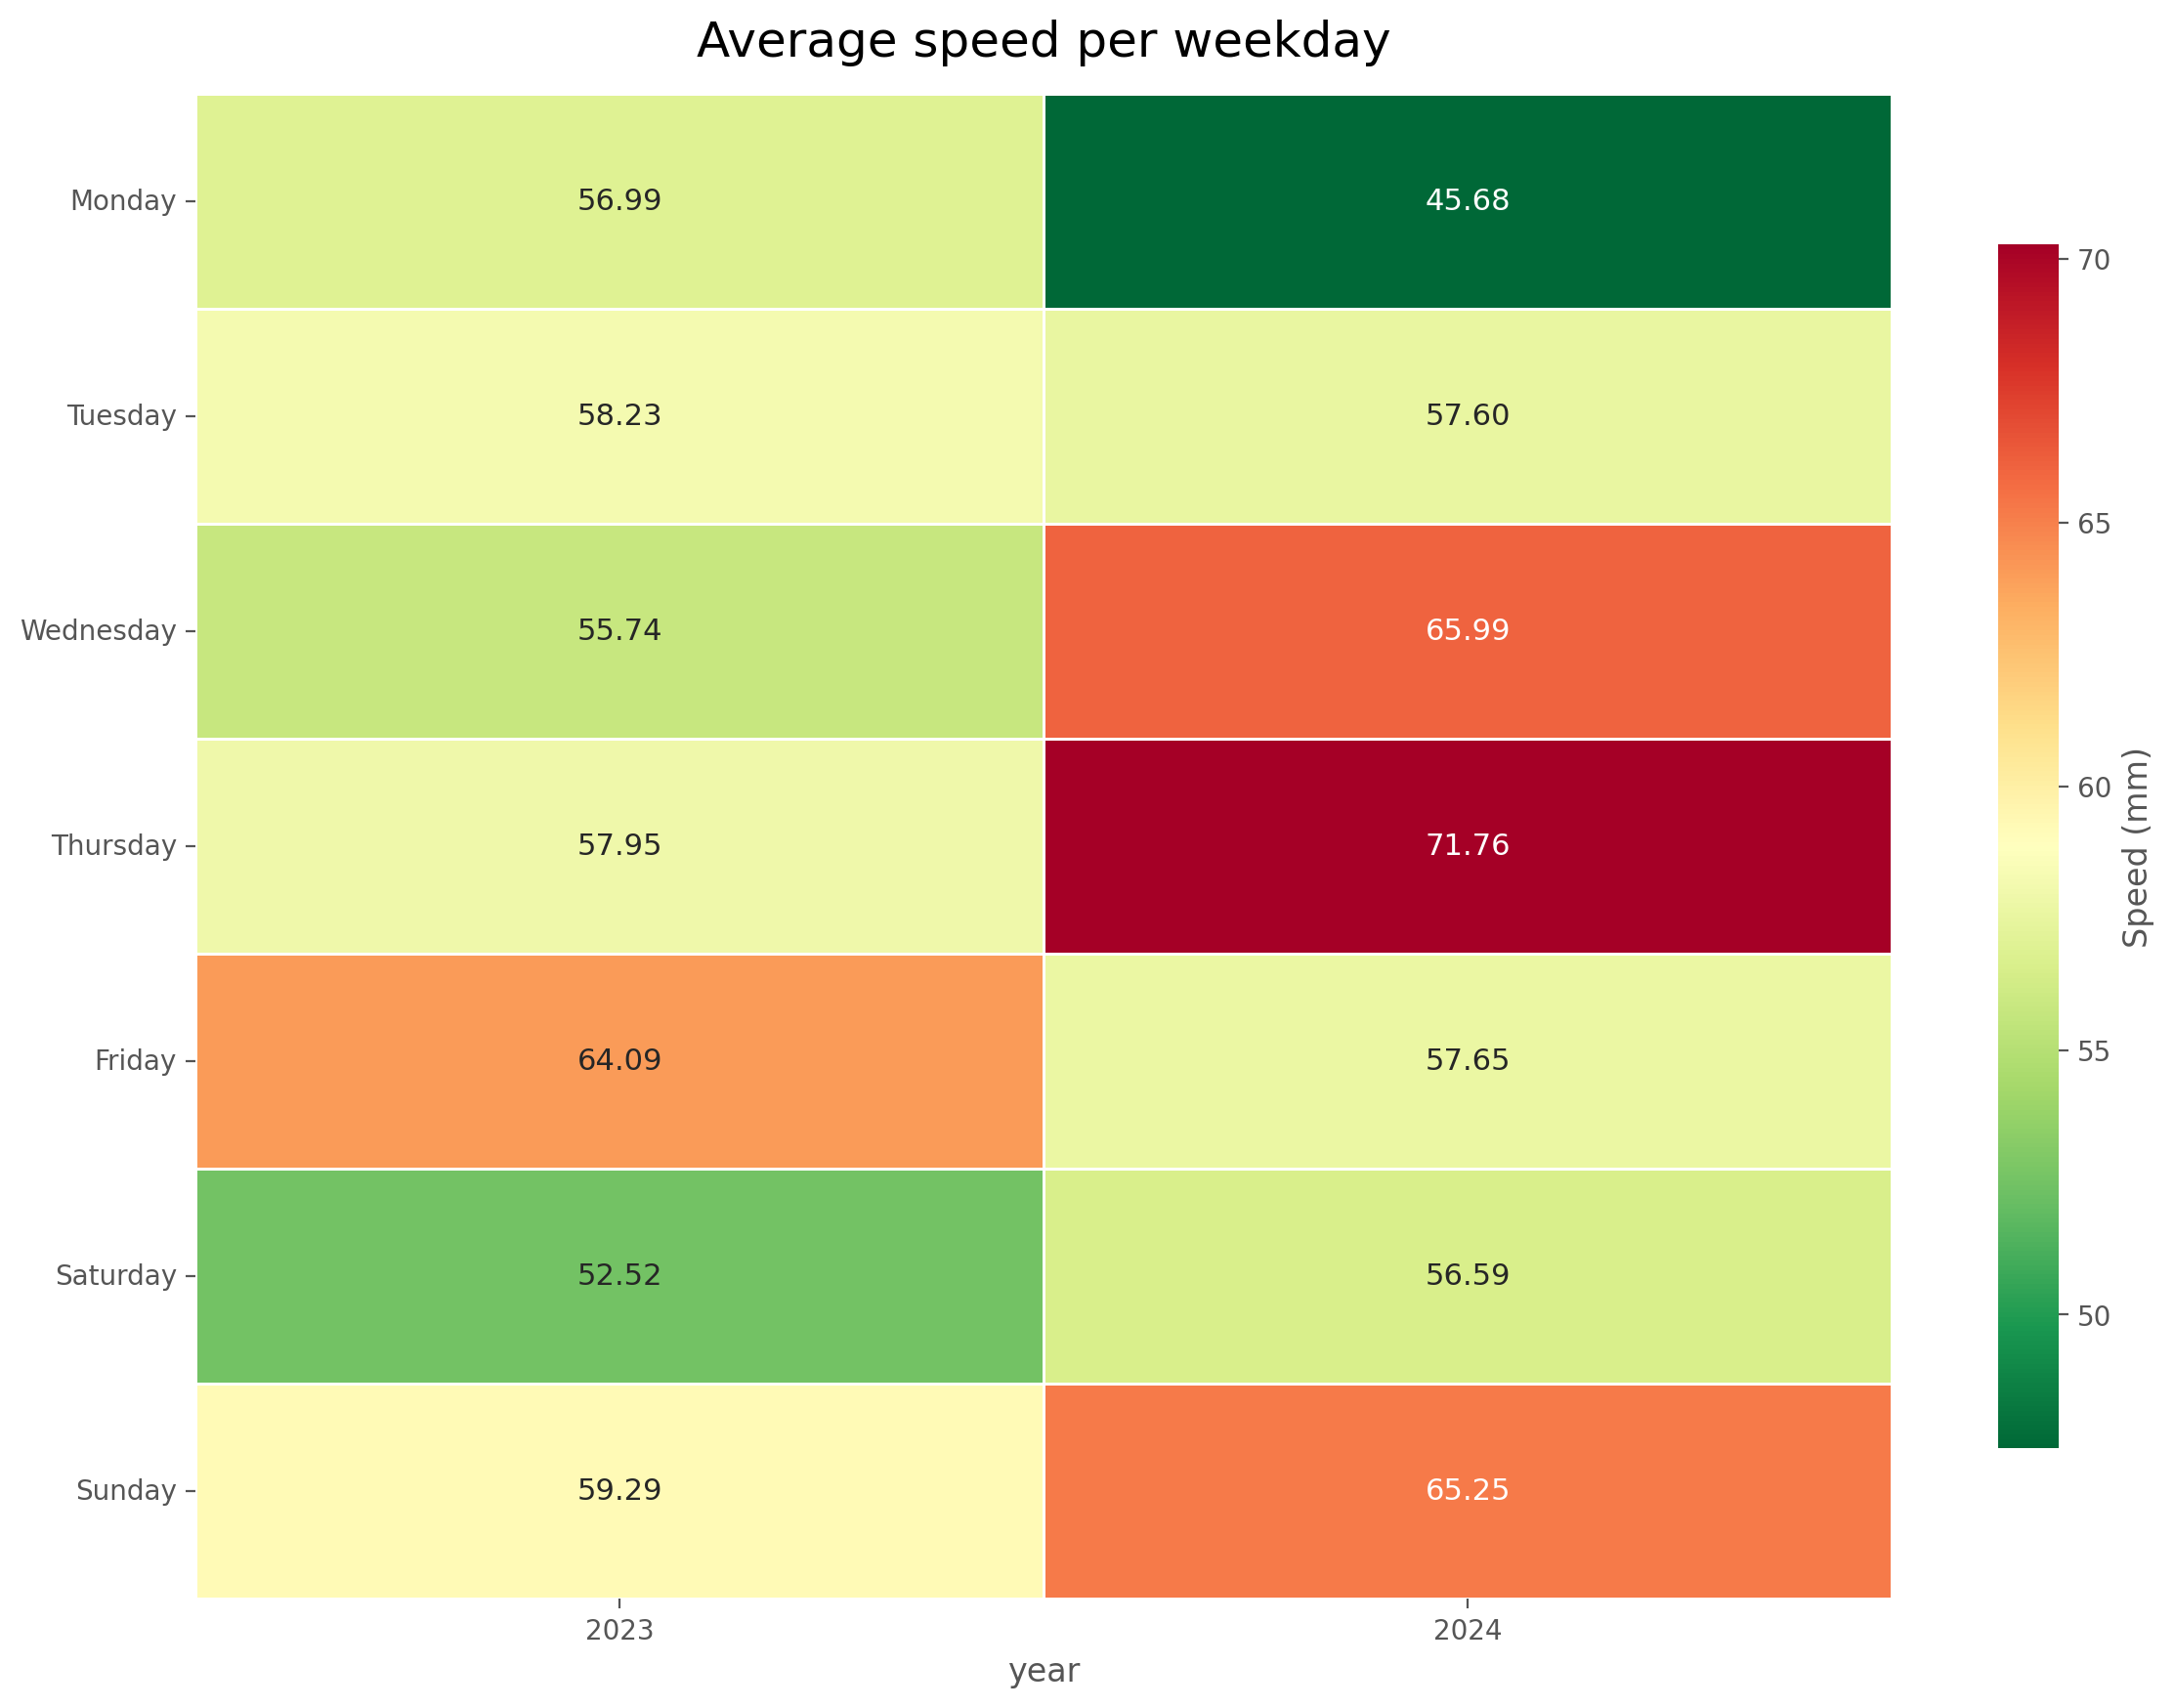

In [28]:
all_weekday_year_df = pd.pivot_table(df, values="speed",index=["weekday"], columns=["year"], fill_value=0.0)
all_weekday_year_df = all_weekday_year_df.set_index([[calendar.day_name[i] for i in list(all_weekday_year_df.index)]])
plot_heatmap(all_weekday_year_df, 'Average speed per weekday')

The aggfunc can be a custom function, it could be interesting to calculate the percentage of days in the month with rain.

In [29]:
all_month_year_percentage_df = pd.pivot_table(df, values="speed",index=["month"], columns=["year"],
                                              aggfunc=lambda x: (x>SLOW_SPEED).sum()/len(x),
                                              fill_value=0,
                                              margins=True)
all_month_year_percentage_df = all_month_year_percentage_df.set_index([[calendar.month_abbr[i] if isinstance(i, int)
                                                                        else i for i in list(all_month_year_percentage_df.index)]])

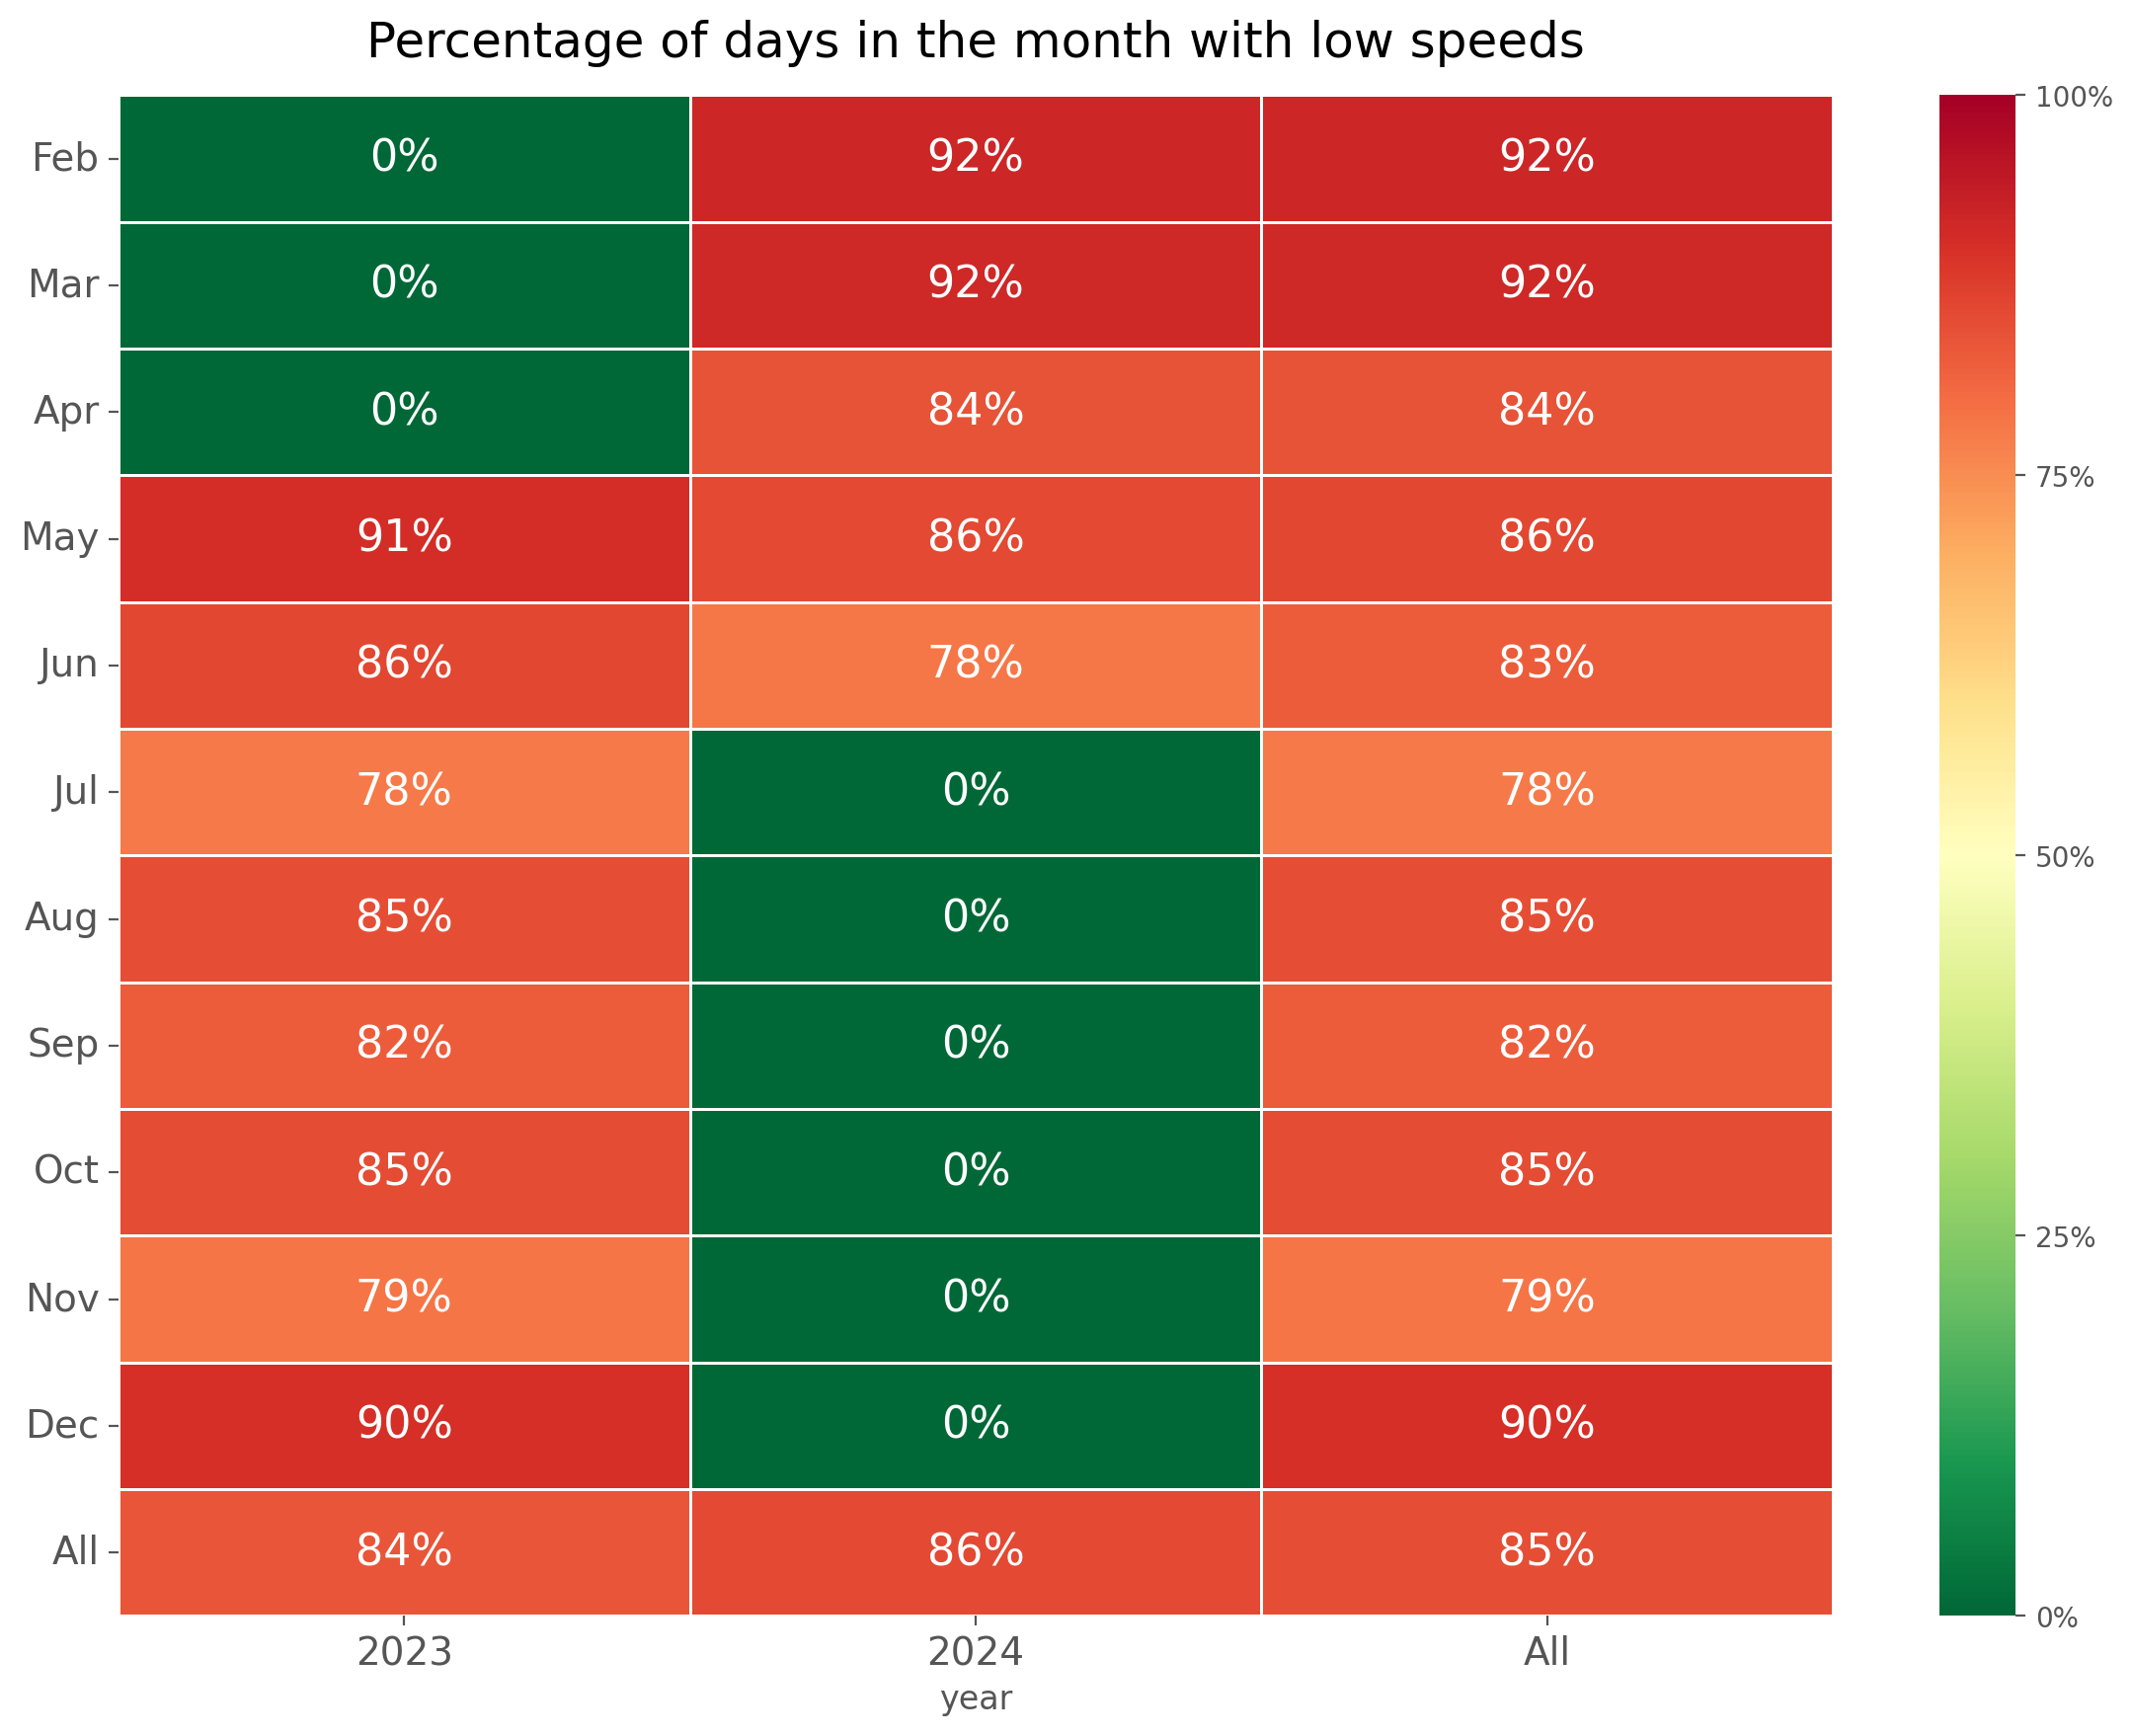

In [31]:
plt.figure(figsize = (14, 10))
ax = sns.heatmap(all_month_year_percentage_df, cmap = 'RdYlGn_r', annot=True, fmt='.0%',
                 vmin=0, vmax=1, linewidths=.5, annot_kws={"size": 16})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50,.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 14)
ax.tick_params(rotation = 0)
plt.title('Percentage of days in the month with low speeds', fontdict={'fontsize':18}, pad=14);

In a similar fashion we can create an aggregation for each day of the year.

In [32]:
def plot_heatmap_year(year):
    plt.figure(figsize = (16, 10))
    allByYear_df = df.loc[df['year'] == year]
    allByYear_df = pd.pivot_table(allByYear_df, values="speed",
                                  index=["month"], columns=["day"], fill_value=None)
    allByYear_df = allByYear_df.set_index([[calendar.month_abbr[i] for i in list(allByYear_df.index)]])
    ax = sns.heatmap(allByYear_df, cmap = 'RdYlGn_r',
                     vmin=0, vmax=20,
                     annot=False, linewidths=.1,
                     annot_kws={"size": 8}, square=True, cbar_kws={"shrink": .48, 'label': 'Rain (mm)'})
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
    ax.tick_params(rotation = 0)
    plt.title(f'speeds {year}', fontdict={'fontsize':18}, pad=14);

/opt/homebrew/Caskroom/miniconda/base/envs/skmob-dev/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/homebrew/Caskroom/miniconda/base/envs/skmob-dev/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


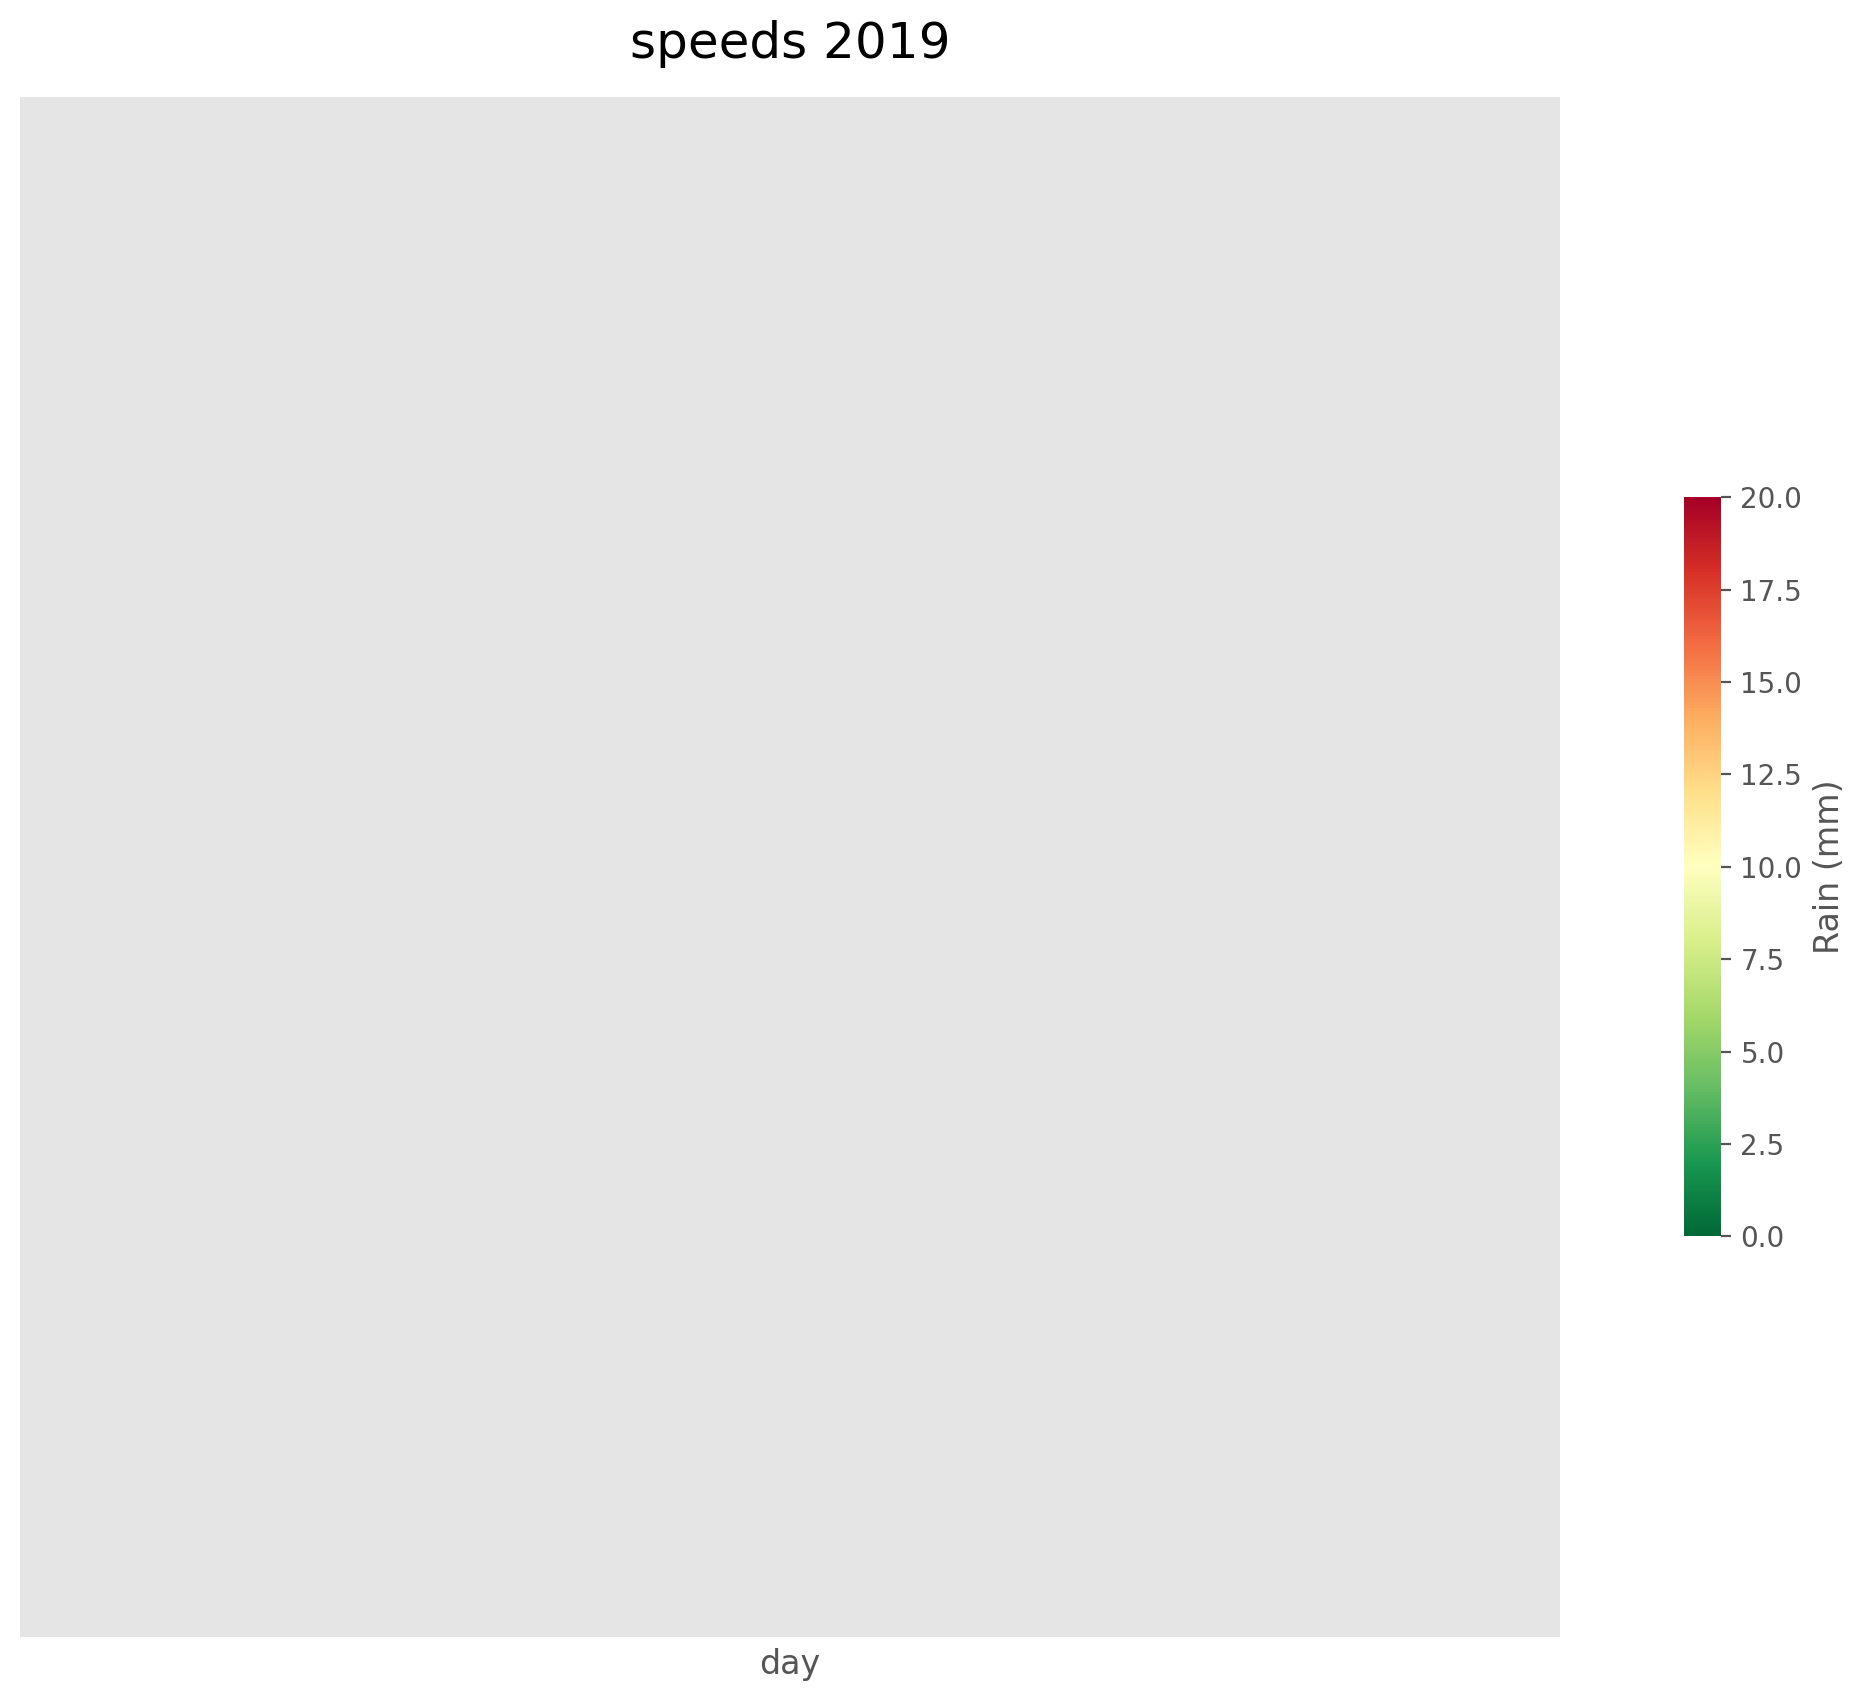

In [33]:
plot_heatmap_year(2019)

/opt/homebrew/Caskroom/miniconda/base/envs/skmob-dev/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/homebrew/Caskroom/miniconda/base/envs/skmob-dev/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


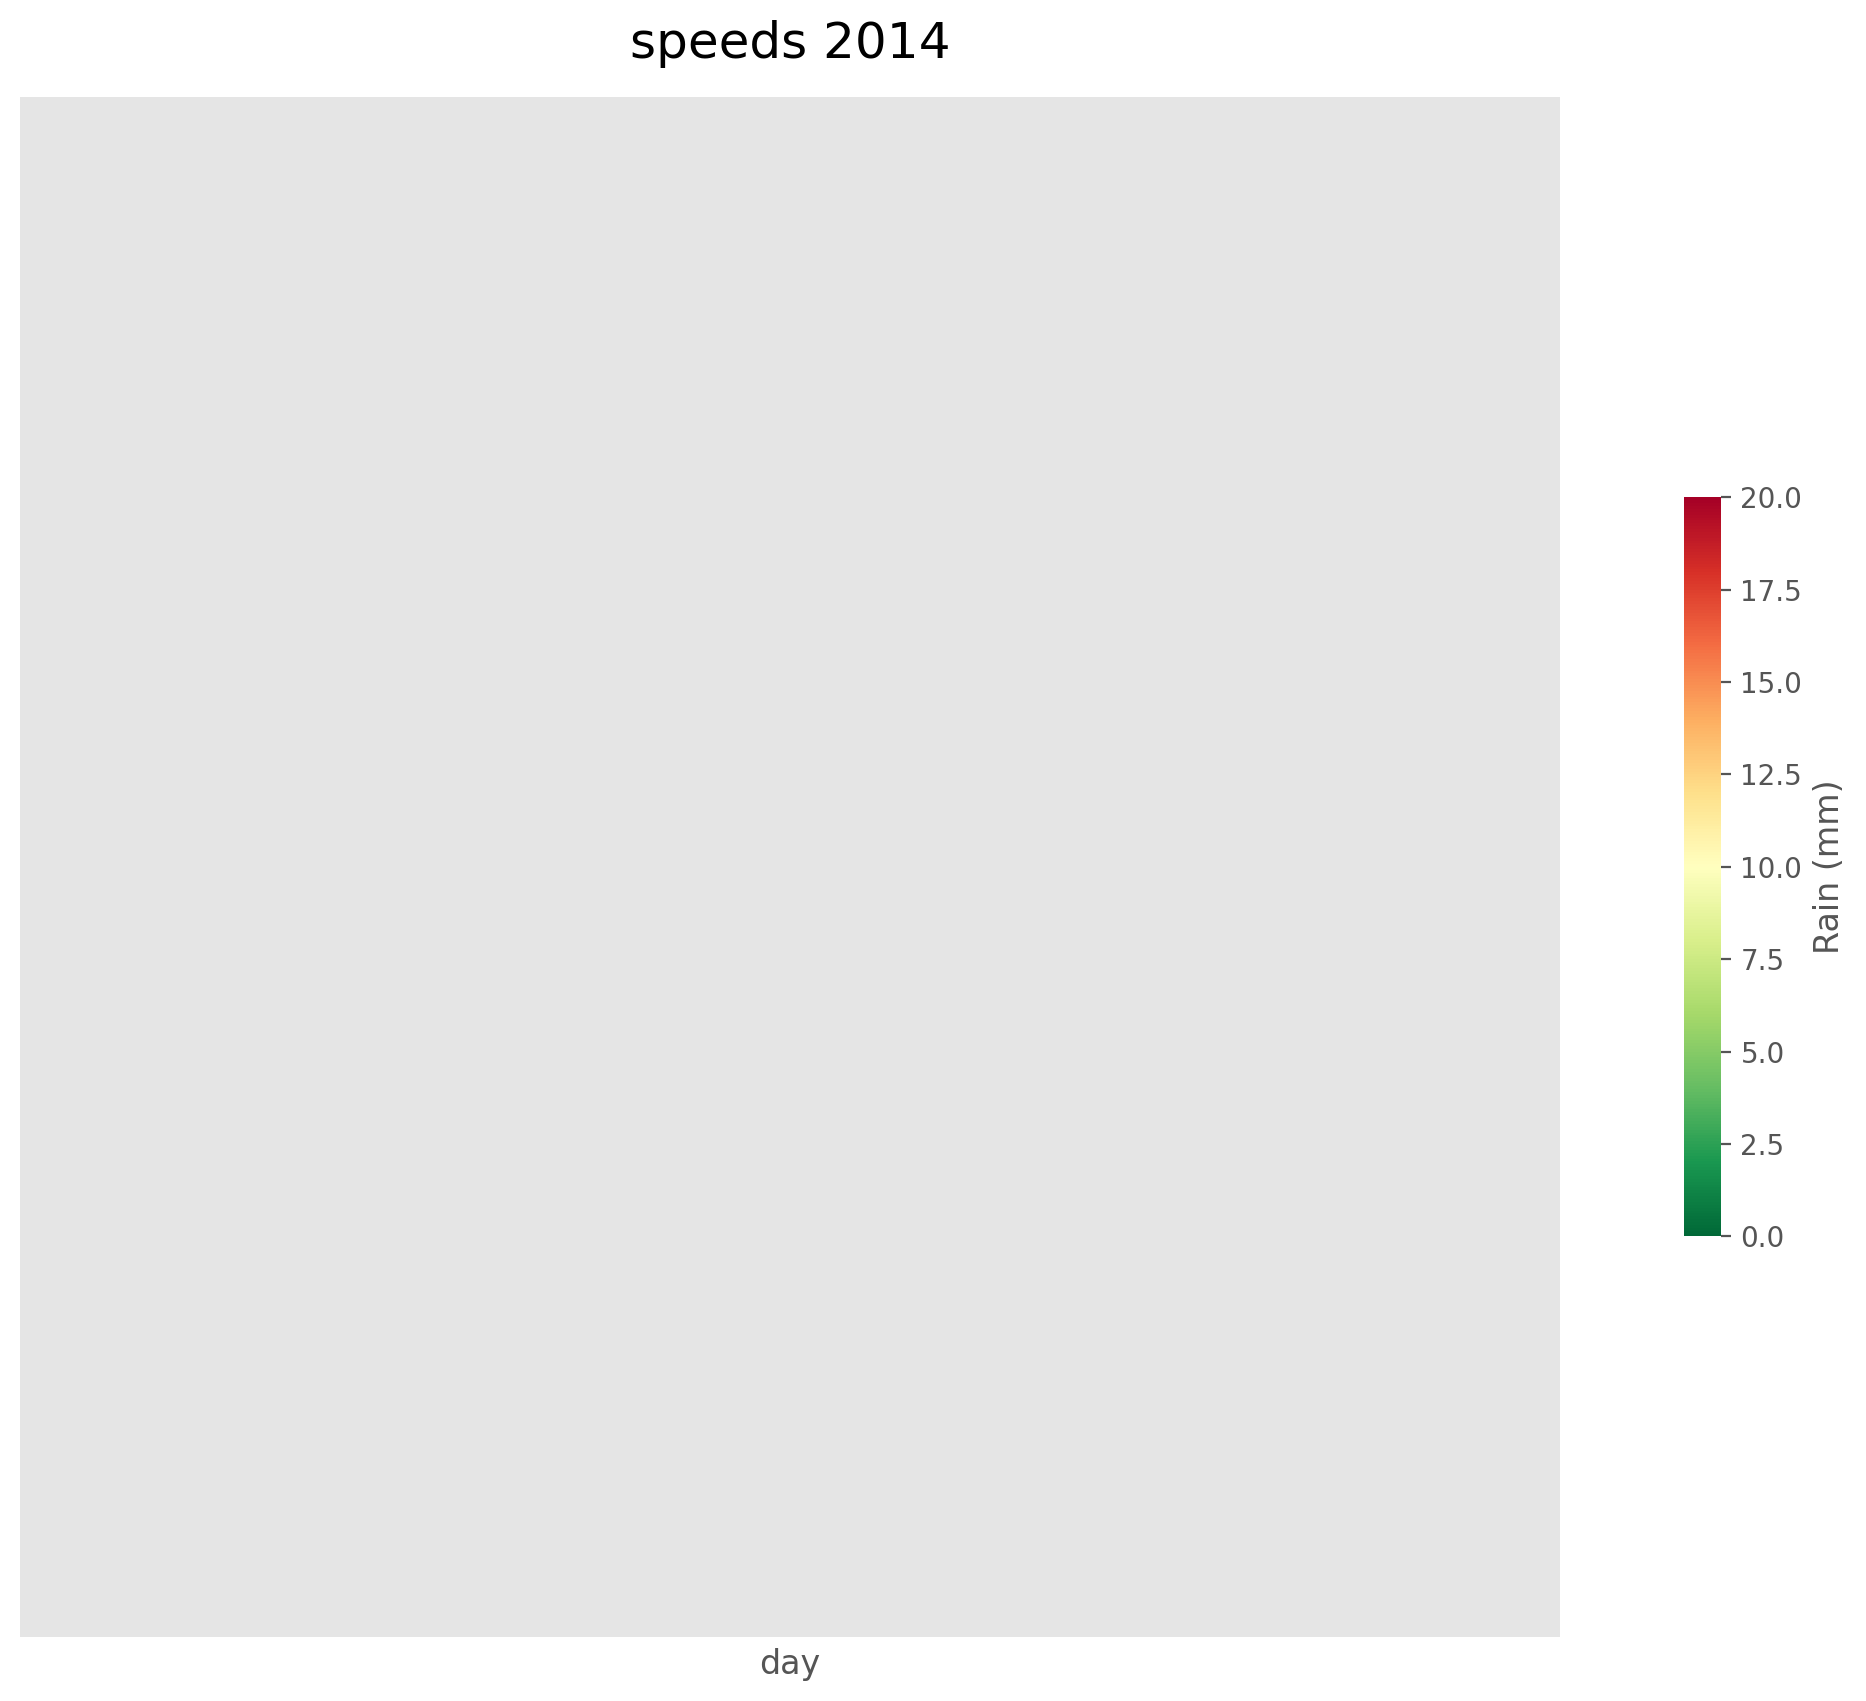

In [34]:
plot_heatmap_year(2014)

In [35]:
all_days_avg_df = df.groupby([= df['datetime']..dt.month, = df['datetime']..dt.day])['speed'].mean()
all_days_avg_df = all_days_avg_df.unstack()
all_days_avg_df = all_days_avg_df.set_index([[calendar.month_abbr[i] for i in list(all_days_avg_df.index)]])

SyntaxError: invalid syntax (2109960825.py, line 1)

Another possibility is to get the mean precipitation for each day of the year considering all the years in the dataset.
In the heatmap a custom colormap was used in order to have greenish cells for very low values.

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def make_colormap(seq):
    """
    Return a LinearSegmentedColormap
    seq: list
        a sequence of floats and RGB-tuples. 
        The floats should be increasing and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [37]:
import matplotlib.colors as colors
c = colors.ColorConverter().to_rgb
gyr = make_colormap([c('green'), c('yellow'), 0.25, c('yellow'), c('red')])

In [38]:
plt.figure(figsize = (20, 14))
ax = sns.heatmap(all_days_avg_df, cmap = gyr, annot=True, fmt='.2f',
                 vmin=0, linewidths=.1,
                 annot_kws={"size": 8}, square=True,  # <-- square cell
                 cbar_kws={"shrink": .5, 'label': 'Rain (mm)'})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
ax.tick_params(rotation = 0)
_ = plt.title('speeds Average 2010-2019', fontdict={'fontsize':18}, pad=14)

NameError: name 'all_days_avg_df' is not defined

<Figure size 2000x1400 with 0 Axes>

Another way to customize the colormap to make highest values more prominent.

In [ ]:
custom_palette = sns.color_palette("GnBu", 6)
custom_palette[5] = sns.color_palette("OrRd", 6)[5]

In [ ]:
sns.palplot(custom_palette)

In [ ]:
plt.figure(figsize = (20, 14))
ax = sns.heatmap(all_days_avg_df, cmap = custom_palette, annot=True, fmt='.2f',
                 vmin=0, linewidths=.1,
                 annot_kws={"size": 8}, square=True,
                 cbar_kws={"shrink": .5, 'label': 'Rain (mm)'})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
ax.tick_params(rotation = 0)
_ = plt.title('speeds Average 2010-2019', fontdict={'fontsize':18}, pad=14)

### CountPlot with customized text

In [ ]:
df.groupby('year')['raining'].sum()

In [ ]:
plt.figure(figsize = (14, 6))
ax = sns.countplot(x="year", hue="raining", data=df.sort_values(by='year'))
ax.legend(loc='upper right', frameon=True, labels=['Dry', 'Rain'])

for p in ax.patches:
    ax.annotate(format(p.get_height()),
                (p.get_x()+p.get_width()/2., p.get_height()-4),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

_ = ax.set_title("Dry and Wet Days per Year")

Something that may be needed when analyzing time series is to calculate the number of consecutive days satisfying a specific condition.
In this case we can try to find the longest spells of dry and rainy days.
One way to do so is to use a combination of diff, cumsum and groupby.
First we need to label each row with an increasing number per each spell.

In [ ]:
df['value_grp'] = (df['raining'].diff() != 0).astype('int').cumsum()

In [ ]:
(df['raining'].diff() != 0).astype('int')

In [ ]:
df.head(10)[['date', 'speed', 'raining', 'value_grp']]

Then we can create a new DataFrame with a row for each label using groupby.

In [ ]:
grouped_values = df.groupby('value_grp')
consecutive_df = pd.DataFrame({'BeginDate' : grouped_values.date.first(), 
              'EndDate' : grouped_values.date.last(),
              'Consecutive' : grouped_values.size(),
              'condition': grouped_values.raining.max() }).reset_index(drop=True)
consecutive_df['condition'].replace({0: 'Dry', 1: 'Rain'}, inplace=True)
consecutive_df.sort_values(by='Consecutive', ascending=False).head(10)

In [ ]:
plt.figure(figsize = (14, 6))
ax = sns.countplot(x='Consecutive', hue='condition', data=consecutive_df.query('Consecutive >= 2'))
ax.set_title('Consecutive days on a specific condition 2012-2019 (> 2 days)', pad=14)
ax.set(xlabel='Consecutive days', ylabel='Count')
_ = plt.legend(loc='upper right')

In [ ]:
consecutive_df['DateRange'] = consecutive_df["BeginDate"].astype(str) + ' -> ' + consecutive_df["EndDate"].astype(str)
ax = sns.barplot(x="Consecutive", y="DateRange", hue="condition", data=consecutive_df.sort_values(by='Consecutive', ascending=False).head(14))

for p in ax.patches:
 width = p.get_width()
 ax.text(width -1.6, p.get_y() + p.get_height()/2. + 0.2,'{:1.0f}'.format(width), ha="center")

In [ ]:
df_top10_per_condition = consecutive_df.sort_values(by='Consecutive',ascending = False).groupby('condition').head(10)

d = {'color': ['g', 'r']}
g = sns.FacetGrid(df_top10_per_condition, row="condition",
                      hue='condition',
                      hue_kws=d,
                      sharey=False)

g.fig.set_figheight(8)
g.fig.set_figwidth(10)
    
_ = g.map(sns.barplot, "Consecutive", "DateRange")
_ = g.set(ylabel='')

# This is just to add the numbers inside the bars
for ax in g.axes.flat:
 for p in ax.patches:
  width = p.get_width()
  _ = ax.text(width -1.6, p.get_y() + p.get_height()/2. + 0.1,'{:1.0f}'.format(width), ha="center")

Create custom palette to use blue for high precipitation values

In [ ]:
custom_palette = sns.diverging_palette(128, 240, n=10)

In [ ]:
sns.palplot(custom_palette)

In [ ]:
plt.figure(figsize = (20, 14))
ax = sns.heatmap(all_days_avg_df, cmap = custom_palette, annot=True, fmt='.2f',
                 vmin=0, linewidths=.1,
                 annot_kws={"size": 8}, square=True,
                 cbar_kws={"shrink": .5, 'label': 'Rain (mm)'})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
ax.tick_params(rotation = 0)
_ = plt.title('speeds Average 2010-2019', fontdict={'fontsize':18}, pad=14)

Running average to identify periods with high precipitations.

In [ ]:
plt.figure(figsize = (18, 6))
plt.title('Avg Rainfall (40 days window)', pad=14)
_ = df.set_index('date')['speed'].rolling(40).mean().plot()

Experimenting with the average temperature

In [ ]:
ops_month_df= df.groupby(['month', 'year']).mean()['avg_temp'].reset_index()
plt.figure(figsize = (14, 6))
ax = sns.boxplot(x = "month", y = "avg_temp", data = ops_month_df)

In [ ]:
df.groupby(['month', 'year']).mean()['avg_temp'].reset_index()

In [ ]:
def plotHeatmap(df, title):
    plt.figure(figsize = (20, 8))

    ax = sns.heatmap(df, cmap = 'RdYlBu_r', fmt='.2f', annot=True,
                     linewidths=.2, annot_kws={"size": 8}, square=True,
                     cbar_kws={"shrink": .9, 'label': 'Temperature °C'})
    cbar = ax.collections[0].colorbar
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 10)
    ax.tick_params(rotation = 0)
    plt.title(title, fontdict={'fontsize':18}, pad=14);

In [ ]:
allMonthYear_df = pd.pivot_table(df, values="avg_temp",index=["month"], columns=["year"], fill_value=None, margins=True)
allMonthYear_df = allMonthYear_df.set_index([[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(allMonthYear_df.index)]])
plotHeatmap(allMonthYear_df, 'Average Temperature')